<a href="https://colab.research.google.com/github/theviderlab/computer_vision/blob/main/notebooks/clip/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mu4nnivt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mu4nnivt
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=5ef03adfc6d36954ea883fdafbfde0c8e14edf9d45f7d0c09817ae5c038776c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-x6g1g1o1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.4.0+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 139MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7909c32843a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import random
import torch
import clip
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR100
from PIL import Image

In [8]:
# Cargar el modelo CLIP y la transformación predefinida
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=device)

In [9]:
# Cargar el conjunto de datos CIFAR-100 sin transformaciones
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=None, download=True)

100%|██████████| 169001437/169001437 [00:12<00:00, 13441660.58it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [10]:
# Obtener la lista de nombres de clases
clases = cifar100.classes

# Preparar las descripciones de texto y tokenizarlas
text_descriptions = [f"This is a photo of a {label}" for label in clases]
text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

print(text_descriptions[:3])
print(text_features[:3])

['This is a photo of a apple', 'This is a photo of a aquarium_fish', 'This is a photo of a baby']
tensor([[-0.0048,  0.0590, -0.0039,  ..., -0.0234, -0.0152, -0.0048],
        [-0.0091, -0.0048,  0.0157,  ...,  0.0345,  0.0006,  0.0177],
        [ 0.0054,  0.0194, -0.0327,  ..., -0.0533, -0.0014, -0.0191]],
       device='cuda:0')


In [11]:
# Seleccionar 3 índices aleatorios
indices = random.sample(range(len(cifar100)), 3)

In [12]:
# Lista para almacenar las imágenes y etiquetas
images = []
labels = []
original_images = []  # Para visualización

for idx in indices:
    image, label = cifar100[idx]
    label_name = clases[label]
    original_images.append((image, label_name))
    # Preprocesar la imagen para CLIP
    image_input = preprocess_clip(image).unsqueeze(0).to(device)
    images.append(image_input)
    labels.append(label)

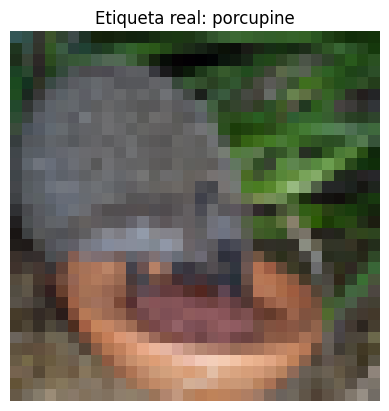

In [13]:
image_id = 2
plt.imshow(original_images[image_id][0])
plt.title(f"Etiqueta real: {original_images[image_id][1]}")
plt.axis('off')
plt.show()

In [14]:
# Concatenar las imágenes en un solo tensor
image_inputs = torch.cat(images, dim=0)

with torch.no_grad():
    # Obtener características de imagen
    image_features = model.encode_image(image_inputs).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

In [15]:
print(image_features[0].shape)
print(text_features[0].shape)

torch.Size([512])
torch.Size([512])


In [16]:
with torch.no_grad():
    # Calcular similitudes manualmente
    similarities = image_features @ text_features.T
    probs = similarities.softmax(dim=-1).cpu().numpy()

In [17]:
with torch.no_grad():
    # Calcular similitud y obtener probabilidades
    logits_per_image, logits_per_text = model(image_inputs, text_tokens)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

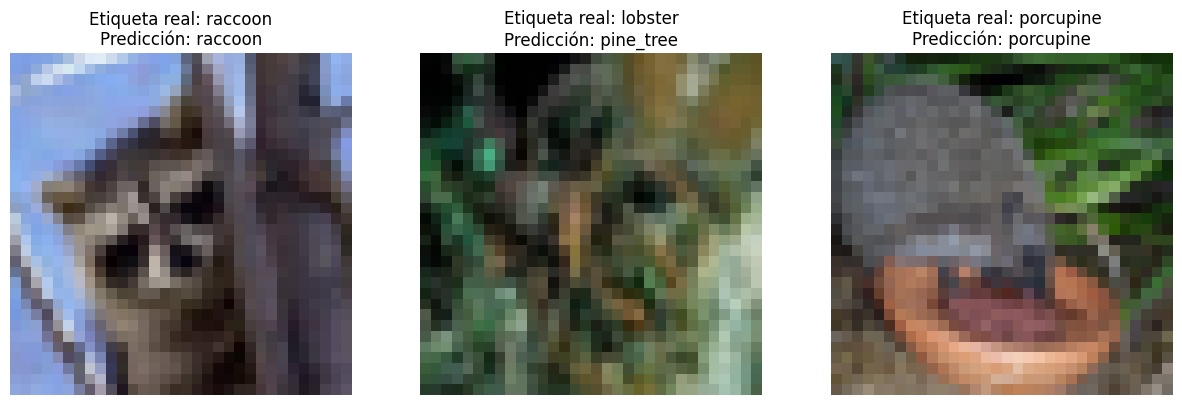

In [18]:
# Mostrar las imágenes con sus predicciones
plt.figure(figsize=(15, 5))
for i in range(len(indices)):
    image, label_name = original_images[i]
    probs_i = probs[i]
    # Obtener las 5 clases más probables
    top5_prob, top5_label = torch.topk(torch.tensor(probs_i), 5)
    top5_classes = [clases[idx] for idx in top5_label.numpy()]
    # Mostrar la imagen
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Etiqueta real: {label_name}\nPredicción: {top5_classes[0]}")
    plt.axis('off')
plt.show()


# Prueba con imágenes de mayor resolución

In [19]:
from torchvision.datasets import STL10

In [20]:
# Cargar el conjunto de datos STL10 sin transformaciones
stl10 = STL10(os.path.expanduser("~/.cache"), split='test', transform=None, download=True)

# Obtener la lista de nombres de clases
clases = stl10.classes

100%|██████████| 2640397119/2640397119 [04:29<00:00, 9794370.81it/s] 


Extracting /root/.cache/stl10_binary.tar.gz to /root/.cache


In [21]:
text_descriptions = [f"This is a photo of a {label}" for label in clases]
text_tokens = clip.tokenize(text_descriptions).to(device)

In [22]:
# Seleccionar 3 índices aleatorios
indices = random.sample(range(len(stl10)), 3)

In [23]:
# Lista para almacenar las imágenes y etiquetas
images = []
labels = []
original_images = []  # Para visualización

for idx in indices:
    image, label = stl10[idx]
    label_name = clases[label]
    original_images.append((image, label_name))
    # Preprocesar la imagen para CLIP
    image_input = preprocess_clip(image).unsqueeze(0).to(device)
    images.append(image_input)
    labels.append(label)

# Concatenar las imágenes en un solo tensor
image_inputs = torch.cat(images, dim=0)

In [24]:
with torch.no_grad():
    # Calcular logits y obtener probabilidades
    logits_per_image, logits_per_text = model(image_inputs, text_tokens)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

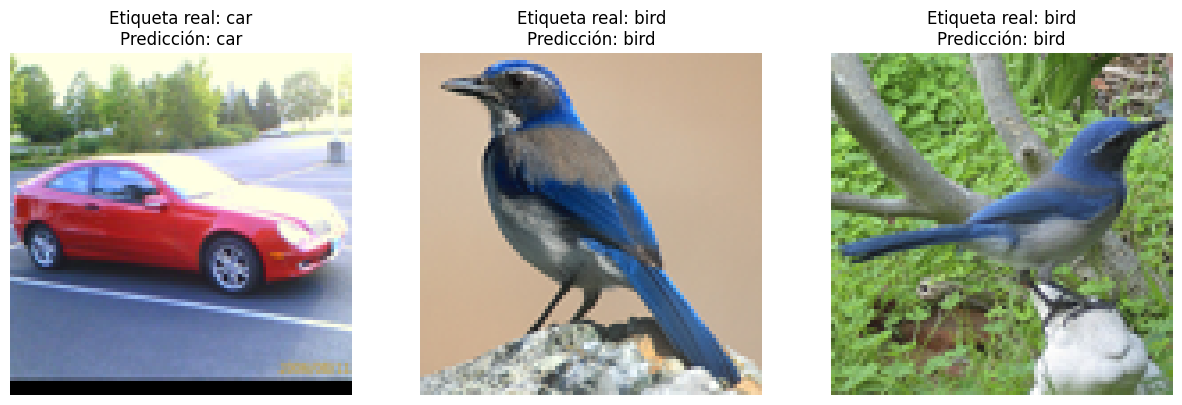

In [25]:
# Mostrar las imágenes con sus predicciones
plt.figure(figsize=(15, 5))
for i in range(len(indices)):
    image, label_name = original_images[i]
    probs_i = probs[i]
    # Obtener las 5 clases más probables
    top5_prob, top5_label = torch.topk(torch.tensor(probs_i), 5)
    top5_classes = [clases[idx] for idx in top5_label.numpy()]
    # Mostrar la imagen
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Etiqueta real: {label_name}\nPredicción: {top5_classes[0]}")
    plt.axis('off')
plt.show()

# Buscar objetos

*   Elemento de lista
*   Elemento de lista



In [71]:
# Ruta a la imagen 'wally.jpg' en el directorio raíz
image_path = os.path.join('/content', 'hidden-objects.jpg')

# Cargar la imagen
image = Image.open(image_path)

# Obtener las dimensiones de la imagen
width, height = image.size

# Convertir la imagen a un array de NumPy
image_array = np.array(image)

print(image.size)

(1920, 1080)


In [76]:
# Definir el tamaño de los parches
patch_dim = 64

# Calcular el número de parches en cada dimensión
num_patches_x = width // patch_dim
num_patches_y = height // patch_dim

In [77]:
# Dividir la imagen en parches y almacenarlos en una matriz 2D
patches_grid = []
for i in range(num_patches_y):
    row_patches = []
    for j in range(num_patches_x):
        # Calcular las coordenadas del parche
        left = j * patch_dim
        upper = i * patch_dim
        right = left + patch_dim
        lower = upper + patch_dim
        # Extraer el parche
        patch = image_array[upper:lower, left:right, :]
        row_patches.append(patch)
    patches_grid.append(row_patches)

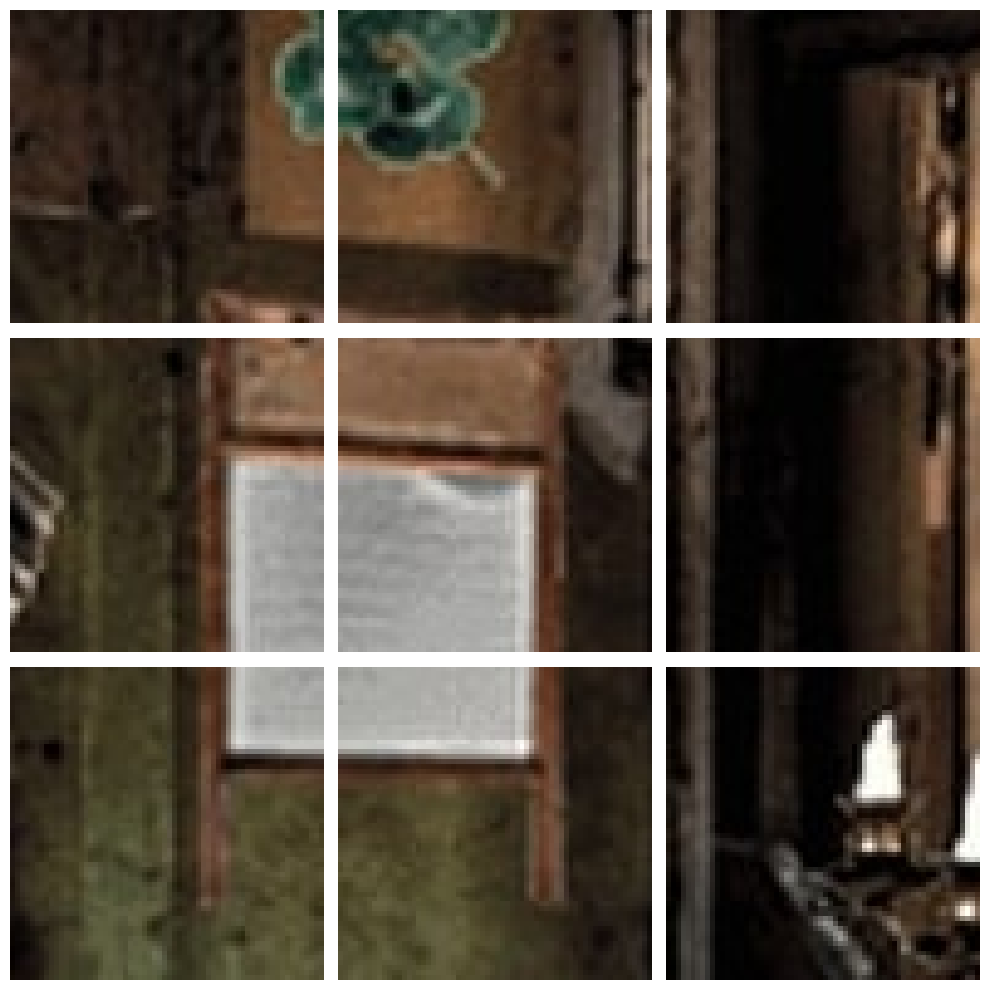

In [89]:
dim_sample = 3

# Seleccionar una posición aleatoria para la esquina superior izquierda del 3x3
max_i = num_patches_y - dim_sample
max_j = num_patches_x - dim_sample

start_i = random.randint(0, max_i)
start_j = random.randint(0, max_j)

# Extraer los 9 parches en una región de dim_samplexdim_sample
selected_patches = []
for i in range(start_i, start_i + dim_sample):
    for j in range(start_j, start_j + dim_sample):
        selected_patches.append(patches_grid[i][j])

# Mostrar los 9 parches seleccionados en su disposición original
plt.figure(figsize=(10, 10))
for idx, patch in enumerate(selected_patches):
    plt.subplot(dim_sample, dim_sample, idx + 1)
    plt.imshow(patch)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [135]:
# Preparar el texto (en inglés para mejores resultados)
text_prompt = "image of a spider"
text_tokens = clip.tokenize([text_prompt]).to(device)
text_features = model.encode_text(text_tokens)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [136]:
# Matriz para almacenar las probabilidades
prob_matrix = np.zeros((num_patches_y - dim_sample + 1, num_patches_x - dim_sample + 1))

In [137]:
prob_matrix.shape

(14, 28)

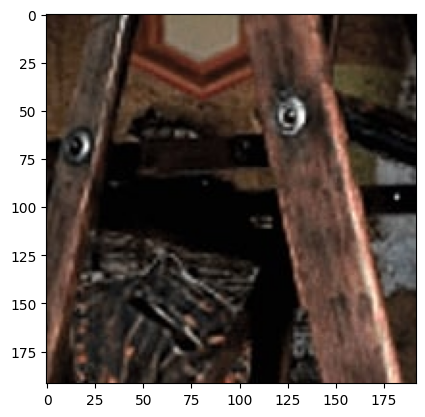

In [138]:
j=3
i=5
left = j * patch_dim
upper = i * patch_dim
right = left + dim_sample * patch_dim
lower = upper + dim_sample * patch_dim

# Extraer la región de la imagen
region = image.crop((left, upper, right, lower))
plt.imshow(region)
plt.show()

In [139]:
# Recorrer la imagen con una ventana deslizante
for i in range(prob_matrix.shape[0]):
    for j in range(prob_matrix.shape[1]):
        # Calcular las coordenadas de la región
        left = j * patch_dim
        upper = i * patch_dim
        right = left + dim_sample * patch_dim
        lower = upper + dim_sample * patch_dim

        # Extraer la región de la imagen
        region = image.crop((left, upper, right, lower))

        # Preprocesar la región para CLIP
        image_input = preprocess_clip(region).unsqueeze(0).to(device)

        with torch.no_grad():
            # Calcular logits y obtener la similitud directamente
            logits_per_image, logits_per_text = model(image_input, text_tokens)
            similarity = logits_per_image.squeeze().cpu().item()

        # Almacenar la similitud en la matriz
        prob_matrix[i, j] = similarity

In [140]:
# Normalizar el mapa de probabilidades entre 0 y 1
similarity_normalized = (prob_matrix - prob_matrix.min()) / (prob_matrix.max() - prob_matrix.min())

# Aplicar la función sigmoide desplazada
# Parámetros ajustables
x0 = 0.65  # Umbral de similitud (entre 0 y 1)
k = 10    # Factor de pendiente (mayor valor = transición más abrupta)

# Aplicar la función sigmoide desplazada
sigmoid_shifted = 1 / (1 + np.exp(-k * (similarity_normalized - x0)))

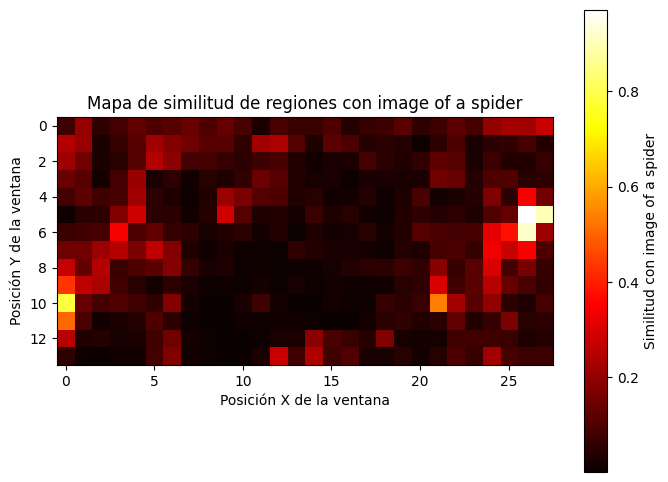

In [141]:
# Mostrar la matriz de probabilidades como una imagen
plt.figure(figsize=(8, 6))
plt.imshow(sigmoid_shifted, cmap='hot', interpolation='nearest')
plt.colorbar(label=f"Similitud con {text_prompt}")
plt.title(f"Mapa de similitud de regiones con {text_prompt}")
plt.xlabel('Posición X de la ventana')
plt.ylabel('Posición Y de la ventana')
plt.show()

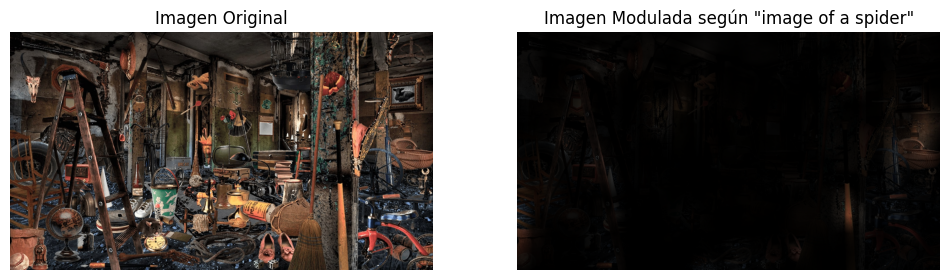

In [142]:
# Redimensionar el mapa de probabilidades al tamaño de la imagen
from scipy.ndimage import zoom

# Calcular el factor de ampliación
zoom_factor_x = width / sigmoid_shifted.shape[1]
zoom_factor_y = height / sigmoid_shifted.shape[0]

# Ampliar el mapa de probabilidades
prob_map_resized = zoom(sigmoid_shifted, (zoom_factor_y, zoom_factor_x), order=1)

# Asegurar que el mapa redimensionado tiene las mismas dimensiones que la imagen
prob_map_resized = prob_map_resized[:height, :width]

# Expandir dimensiones para que pueda multiplicarse con la imagen RGB
prob_map_rgb = np.stack([prob_map_resized]*3, axis=-1)

# Modificar la intensidad de la imagen original
image_array_modulated = image_array.astype(np.float32) * prob_map_rgb

# Asegurar que los valores están en el rango [0, 255]
image_array_modulated = np.clip(image_array_modulated, 0, 255).astype(np.uint8)

# Convertir el array modulado a imagen PIL
image_modulated = Image.fromarray(image_array_modulated)

# Mostrar la imagen original y la imagen modulada
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_modulated)
plt.title(f'Imagen Modulada según "{text_prompt}"')
plt.axis('off')

plt.show()

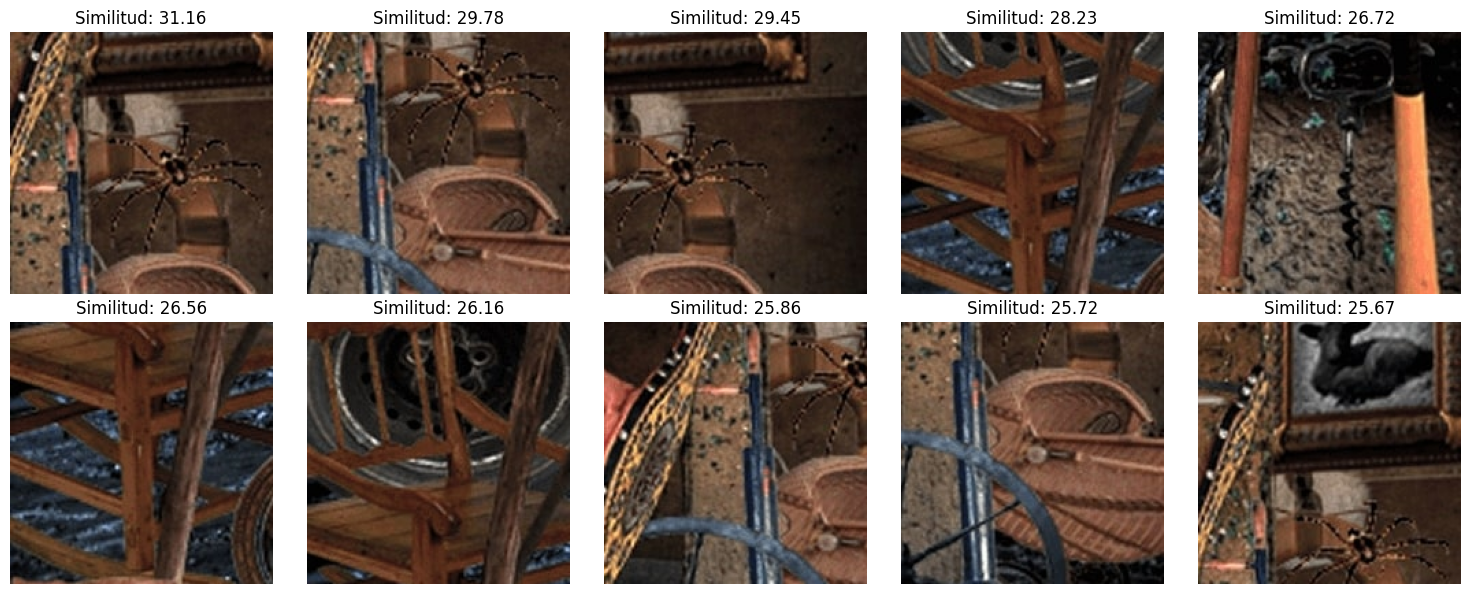

In [143]:
# Después de calcular 'prob_matrix' y realizar las transformaciones deseadas

# Número de parches a mostrar
num_top_patches = 10

# Obtener los índices de los parches con mayor similitud
# Aplanar la matriz de similitudes y obtener los índices de los mayores valores
flat_indices = np.argpartition(prob_matrix.flatten(), -num_top_patches)[-num_top_patches:]
# Ordenar los índices en orden descendente de similitud
sorted_indices = flat_indices[np.argsort(-prob_matrix.flatten()[flat_indices])]

# Convertir los índices planos a coordenadas 2D
coordinates = [np.unravel_index(idx, prob_matrix.shape) for idx in sorted_indices]

# Extraer y mostrar los parches correspondientes
plt.figure(figsize=(15, 6))
for idx, (i, j) in enumerate(coordinates):
    # Calcular las coordenadas de la región
    left = j * patch_dim
    upper = i * patch_dim
    right = left + dim_sample * patch_dim
    lower = upper + dim_sample * patch_dim

    # Extraer la región de la imagen
    region = image.crop((left, upper, right, lower))

    # Mostrar el parche
    plt.subplot(2, 5, idx + 1)
    plt.imshow(region)
    plt.title(f"Similitud: {prob_matrix[i, j]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()